In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist 
import os

# from lenskit.datasets import ML100K, MovieLens
# from lenskit.algorithms import Recommender, als
# from lenskit import batch, topn


import trecs
from trecs.models import ImplicitMF, ImplicitMFLFD, ContentFiltering
from trecs.random import Generator
from trecs.metrics import MSEMeasurement, AverageFeatureScoreRange, RecSimilarity, InteractionSimilarity, Measurement
from trecs.components import Users


In [2]:
GENERATOR = np.random.default_rng(1234)

In [3]:
# basically just recommends items based on the estimates of user preferences!
# this will form the basis of our "ideal" recommender
class IdealRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        pass
    
    def process_new_items(self, new_items):
        """
        Generate zero attributes for new items. Remember,
        this doesn't actually matter because the IdealRecommender
        uses its perfect score function, not
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation

# random recommender - randomly update users at every step
class RandomRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        self.items_hat[:, :] = GENERATOR.random(self.items_hat.shape)
        self.users_hat[:, :] = GENERATOR.random(self.users_hat.shape)
        
    def process_new_items(self, new_items):
        """
        Generate random attributes for new items.
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation

In [4]:
class ShownMedianPrediction(Measurement):
    """
    Measures the median predicted value of recommended items.

    TODO Description

    This class inherits from :class:`.Measurement`.

    Parameters
    -----------

        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.

    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`

        name: str (optional, default: "afsr")
            Name of the measurement component.
    """

    def __init__(self, name="shown_median_prediction", verbose=False):
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        """
        Measures the mean of the distance between all pairwise distances between recommendations

        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.

            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        items_shown = kwargs.pop("items_shown", None)
        predicted_shown_vals=recommender.predicted_scores.value[np.expand_dims(np.arange(recommender.predicted_scores.value.shape[0]), -1), 
                                                items_shown]

        shown_median=np.median(predicted_shown_vals)

        self.observe(shown_median)


In [5]:
class InteractedMedianPrediction(Measurement):
    """
    Measures the median predicted value of recommended items.

    TODO Description

    This class inherits from :class:`.Measurement`.

    Parameters
    -----------

        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.

    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`

        name: str (optional, default: "afsr")
            Name of the measurement component.
    """

    def __init__(self, name="interacted_median_prediction", verbose=False):
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        """
        Measures the mean of the distance between all pairwise distances between recommendations

        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.

            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        interactions = kwargs.pop("interactions", None)
        
        if interactions is None:
            raise ValueError(
                "interactions must be passed in to InteractedMedianPrediction `measure` "
                "method as a keyword argument"
            )
        predicted_int_vals=recommender.predicted_scores.value[np.expand_dims(np.arange(recommender.predicted_scores.value.shape[0]), -1), 
                                                interactions]

        int_median=np.median(predicted_int_vals)

        self.observe(int_median)


In [6]:
class MeanRecDistance(Measurement):
    """
    Cacluates the mean distance between items in each users' recommendation list based on their item attributes
    This class inherits from :class:`.Measurement`.
    Parameters
    -----------
        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.
    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`
        name: str (optional, default: "mean_rec_distance")
            Name of the measurement component.
    """

    def __init__(self, name="mean_rec_distance", verbose=False, distance_metric="cosine"):
        Measurement.__init__(self, name, verbose, init_value=None)
        self.distance_metric=distance_metric

    def measure(self, recommender, **kwargs):
        """
        TODO
        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.
            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        items_shown = kwargs.pop("items_shown", None)

        recommended_item_attr = recommender.items_hat.value[:, items_shown]
        
        user_distances = []
        
        for userid in range(recommended_item_attr.shape[1]):
            user_rec_attr=recommended_item_attr[:,userid,:]

            #take the upper triangle to reduce duplicates
            upper = np.triu(pairwise_distances(user_rec_attr.T, metric=self.distance_metric))
            #replace 0s with nans so the distance to self doesn't get included
            upper = np.where(upper==0, np.nan, upper)

            mean_rec_distance = np.nanmean(upper)
            user_distances.append(mean_rec_distance)
        
        mean_rec_distance=np.mean(np.array(user_distances))
        
        self.observe(mean_rec_distance)


In [7]:
model_params = {'iterations': 100}
# NUM_USERS = 500
# NUM_ITEMS= 1000
# N_FACTORS = 15

NUM_USERS = 100
NUM_ITEMS = 1250
N_FACTORS = 10
NUM_STARTUP = 20
NUM_STEPS = 105
js_pairs = [(u1_idx, u2_idx) for u1_idx in range(NUM_USERS) for u2_idx in range(NUM_USERS) if u1_idx != u2_idx] 

# user_rep = GENERATOR.normal(size=(NUM_USERS, N_FACTORS))
# #USERS = Users(size=(NUM_USERS, N_FACTORS), repeat_interactions=False)
# u = Users(actual_user_scores = user_rep, size=(NUM_USERS, N_FACTORS), num_users=NUM_USERS, repeat_interactions=False)



In [8]:
#mf = ImplicitMF(num_users=NUM_USERS, num_items=NUM_ITEMS, num_latent_factors=N_FACTORS, num_items_per_iter=10,
#                model_params=model_params)

mf = ImplicitMF(actual_user_representation=Users(repeat_interactions=False, size=(NUM_USERS, N_FACTORS)), 
                num_items=NUM_ITEMS, num_latent_factors=N_FACTORS, num_items_per_iter=10,
                model_params=model_params)

#print(mf.num_items)
#
mf.add_metrics(MSEMeasurement())
mf.add_metrics(AverageFeatureScoreRange())
#mf.add_metrics(RecSimilarity(pairs=js_pairs))
mf.add_metrics(InteractionSimilarity(pairs=js_pairs))
mf.add_metrics(ShownMedianPrediction())
mf.add_metrics(InteractedMedianPrediction())
mf.add_metrics(MeanRecDistance())

mf.add_state_variable(mf.predicted_scores)
mf.add_state_variable(mf.users.actual_user_scores)
mf.startup_and_train(NUM_STARTUP)
#mf.users.repeat_interactions=False
mf.run(timesteps=NUM_STEPS, train_between_steps=True, reset_interactions=False)
#mf.run(timesteps=NUM_STEPS)

100%|██████████| 20/20 [00:01<00:00, 12.12it/s]
/Users/amywinecoff/Documents/CITP/Research/Github/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this overwrites the MF model with a model fit only to the latest interaction. To avoid this behavior, set train_between_steps to False.
  "train_between_steps is set to True. Note that, at each step, this "
100%|██████████| 105/105 [01:36<00:00,  1.08it/s]


In [9]:
mflfd = ImplicitMFLFD(actual_user_representation=Users(repeat_interactions=False, size=(NUM_USERS, N_FACTORS)), 
                      num_items=NUM_ITEMS, num_latent_factors=N_FACTORS, num_items_per_iter=10,
                     top_n_limit=50, model_params=model_params)

mflfd.add_metrics(MSEMeasurement())
mflfd.add_metrics(AverageFeatureScoreRange())
#mflfd.add_metrics(RecSimilarity(pairs=js_pairs))
mflfd.add_metrics(InteractionSimilarity(pairs=js_pairs))
mflfd.add_metrics(ShownMedianPrediction())
mflfd.add_metrics(InteractedMedianPrediction())
mflfd.add_metrics(MeanRecDistance())

mflfd.add_state_variable(mflfd.predicted_scores)
mflfd.add_state_variable(mflfd.users.actual_user_scores)
mflfd.startup_and_train(20)
mflfd.run(timesteps=NUM_STEPS, train_between_steps=True, reset_interactions=False)
#mflfd.run(timesteps=NUM_STEPS)

100%|██████████| 20/20 [00:01<00:00, 11.56it/s]
/Users/amywinecoff/Documents/CITP/Research/Github/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this overwrites the MF model with a model fit only to the latest interaction. To avoid this behavior, set train_between_steps to False.
  "train_between_steps is set to True. Note that, at each step, this "
100%|██████████| 105/105 [01:53<00:00,  1.08s/it]


In [19]:
mf.predicted_scores.value

array([[-0.02226966, -0.00055983,  0.03989753, ..., -0.00779777,
         0.04571483,  0.01084603],
       [ 0.00228074,  0.00333271,  0.00899089, ...,  0.00171136,
         0.04993785, -0.00323248],
       [ 0.04393452,  0.01832266, -0.01148353, ...,  0.01779064,
        -0.01480666, -0.02012747],
       ...,
       [ 0.02797793, -0.00433885,  0.00599999, ...,  0.00615345,
         0.0078112 ,  0.02454699],
       [ 0.01854403,  0.01918045,  0.03133535, ...,  0.00491851,
         0.00750403,  0.02703437],
       [ 0.0229371 ,  0.0369304 ,  0.01513944, ...,  0.04055995,
        -0.00076103,  0.03539176]])

In [ ]:
# rla = topn.RecListAnalysis()
# rla.add_metric(topn.ndcg)
# #results = rla.compute(all_recs, test_data)
# #results.head()
# mf.actual_user_item_scores



In [54]:
mf.users.actual_user_scores.value[3,2]
print(mf.users.actual_user_scores.shape)
print(mf.users.actual_user_scores.shape)

(100, 1250)


In [61]:
# mf.users.actual_user_scores.shape[1]
#print(mf.users.actual_user_profiles.value[3,:])
#print(mf.actual_item_attributes[:,2])
m=np.dot(mf.users.actual_user_profiles.value, mf.actual_item_attributes)
pd.DataFrame(m).head(10)

,0,1,2,3,4,5,6,7,8,9,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249
0,-3.248862,-4.455997,2.795254,-1.763477,-2.346849,2.411768,3.731847,1.680373,-4.728657,1.056869,...,4.887864,-1.471810,-5.242794,4.215584,1.710592,7.946939,2.293498,-6.517266,-1.565333,3.215610
1,-2.732082,-3.202192,-2.244852,-0.305169,-0.820216,0.682926,-0.368888,-0.316062,0.226425,-0.153486,...,2.650610,-1.441577,0.651530,3.054689,2.729076,2.560030,0.659823,-1.657007,-0.087455,0.969770
2,-5.634148,4.312912,-0.341870,-5.770473,1.737544,-2.631904,0.007664,-1.517531,1.207187,0.857854,...,-4.368824,0.985312,2.448460,-7.254320,-1.707760,-3.991204,2.567857,2.189877,1.998465,1.609298
3,2.102622,-0.612150,5.456503,1.653090,1.158950,0.754128,1.747341,-1.468375,-1.778603,-1.541270,...,0.330840,-0.099143,-4.082725,-0.317783,-1.793709,3.587194,-1.436227,-1.622313,-1.018262,0.802480
4,-9.748538,3.937356,0.629533,-9.264421,0.117005,-3.816215,-5.985774,-5.304639,8.800023,-2.055456,...,1.786454,1.981371,5.951830,-9.322643,-1.968751,-3.833217,1.588217,5.316552,5.277146,2.324141
5,0.561166,-0.396493,2.429516,6.091988,1.309290,4.183932,4.797084,-1.279602,-2.814015,-3.839752,...,0.880624,-0.937307,-4.115952,4.749371,1.590251,2.705297,-3.142739,-1.886414,-5.829363,2.099613
6,-9.973826,4.254388,-3.194693,-2.138585,-1.333890,2.830610,0.727184,-0.040507,2.369414,0.139021,...,3.640807,-0.341917,1.626150,-0.657663,2.966643,-4.662067,1.345133,1.350171,0.441361,3.737403
7,-1.085570,-6.762099,3.200487,3.590926,1.611036,6.546851,4.028307,-1.355954,-3.639227,-1.065402,...,3.444849,-0.470394,-3.642132,2.478636,1.385210,1.364320,-2.555524,-3.949480,1.094133,6.451240
8,4.447104,-3.542267,-1.414491,1.719240,2.218438,-2.579871,-1.571492,-0.423177,-1.386850,1.987516,...,-3.132029,-2.422701,0.215149,0.429969,0.219265,2.198207,0.294930,-1.283527,2.423380,-2.945185
9,4.493449,-0.118256,3.836732,0.242598,-4.416000,-0.265674,-1.135871,3.820396,0.115771,2.816977,...,4.513929,1.334441,-3.727366,2.116346,-1.058238,4.298573,-0.509752,-0.852890,1.016759,-2.149587


In [62]:
pd.DataFrame(mf.users.actual_user_scores.value).head(10)

,0,1,2,3,4,5,6,7,8,9,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249
0,-0.994789,-1.364409,0.855896,-0.539970,-0.718596,0.738474,1.142677,0.514524,-1.447896,0.323609,...,1.496645,-0.450662,-1.605323,1.290795,0.523777,2.433322,0.702260,-1.995561,-0.479299,0.984607
1,-1.397066,-1.637459,-1.147918,-0.156050,-0.419422,0.349218,-0.188633,-0.161620,0.115784,-0.078486,...,1.355404,-0.737158,0.333164,1.562033,1.395528,1.309086,0.337404,-0.847320,-0.044720,0.495897
2,-1.987583,1.521485,-0.120603,-2.035675,0.612961,-0.928468,0.002704,-0.535346,-inf,0.302629,...,-1.541209,0.347593,0.863754,-2.559138,-0.602454,-1.407994,0.905874,0.772532,0.705007,0.567719
3,1.135992,-0.330729,-inf,0.893121,0.626151,0.407436,0.944043,-0.793325,-0.960933,-0.832708,...,0.178744,-0.053565,-2.205790,-0.171690,-0.969094,-inf,-0.775956,-0.876494,-0.550140,0.433559
4,-2.303678,0.930437,0.148765,-2.189277,0.027649,-0.901810,-1.414499,-1.253540,-inf,-0.485725,...,0.422157,0.468218,1.406478,-2.203035,-0.465236,-0.905828,0.375312,1.256355,1.247043,0.549218
5,-inf,-0.138553,0.848983,2.128817,0.457525,1.462056,1.676319,-0.447151,-0.983345,-1.341784,...,0.307730,-0.327538,-1.438300,1.659646,0.555706,0.945354,-1.098216,-0.659199,-2.037044,0.733700
6,-3.259791,1.390481,-1.044136,-0.698964,-0.435961,0.925141,0.237669,-0.013239,0.774406,0.045437,...,1.189942,-0.111750,0.531482,-0.214947,0.969601,-1.523725,0.439636,0.441283,0.144252,1.221512
7,-0.364308,-2.269304,1.074057,1.205085,0.540650,2.197069,1.351866,-0.455047,-1.221294,-0.357540,...,-inf,-0.157860,-1.222269,0.831810,0.464865,0.457854,-0.857613,-1.325413,0.367182,2.164982
8,1.886959,-1.503026,-0.600185,0.729494,0.941310,-1.094670,-0.666802,-0.179559,-0.588457,0.843327,...,-1.328957,-1.027981,0.091290,0.182441,0.093037,0.932725,0.125142,-0.544616,1.028269,-1.249677
9,1.778341,-0.046801,1.518437,0.096011,-1.747689,-0.105144,-0.449536,-inf,0.045818,1.114855,...,1.786446,0.528122,-1.475154,0.837571,-0.418812,1.701216,-0.201741,-0.337542,0.402396,-0.850727


In [59]:
#col_names = [str(c) for c in mf.users.actual_user_scores.shape[1]]
cols = [f"item_{c}" for c in range(mf.users.actual_user_scores.shape[1])]
actual_scores_df=pd.DataFrame(mf.users.actual_user_scores.value)
actual_scores_df['user']=actual_scores_df.index
actual_scores_df.columns = cols + ['user'] 
#pd.wide_to_long(actual_scores_df, "item_", i="user", j="item").reset_index()

actual_scores_df.head(10)
#print(cols)

,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,...,item_1241,item_1242,item_1243,item_1244,item_1245,item_1246,item_1247,item_1248,item_1249,user
0,-0.994789,-1.364409,0.855896,-0.539970,-0.718596,0.738474,1.142677,0.514524,-1.447896,0.323609,...,-0.450662,-1.605323,1.290795,0.523777,2.433322,0.702260,-1.995561,-0.479299,0.984607,0
1,-1.397066,-1.637459,-1.147918,-0.156050,-0.419422,0.349218,-0.188633,-0.161620,0.115784,-0.078486,...,-0.737158,0.333164,1.562033,1.395528,1.309086,0.337404,-0.847320,-0.044720,0.495897,1
2,-1.987583,1.521485,-0.120603,-2.035675,0.612961,-0.928468,0.002704,-0.535346,-inf,0.302629,...,0.347593,0.863754,-2.559138,-0.602454,-1.407994,0.905874,0.772532,0.705007,0.567719,2
3,1.135992,-0.330729,-inf,0.893121,0.626151,0.407436,0.944043,-0.793325,-0.960933,-0.832708,...,-0.053565,-2.205790,-0.171690,-0.969094,-inf,-0.775956,-0.876494,-0.550140,0.433559,3
4,-2.303678,0.930437,0.148765,-2.189277,0.027649,-0.901810,-1.414499,-1.253540,-inf,-0.485725,...,0.468218,1.406478,-2.203035,-0.465236,-0.905828,0.375312,1.256355,1.247043,0.549218,4
5,-inf,-0.138553,0.848983,2.128817,0.457525,1.462056,1.676319,-0.447151,-0.983345,-1.341784,...,-0.327538,-1.438300,1.659646,0.555706,0.945354,-1.098216,-0.659199,-2.037044,0.733700,5
6,-3.259791,1.390481,-1.044136,-0.698964,-0.435961,0.925141,0.237669,-0.013239,0.774406,0.045437,...,-0.111750,0.531482,-0.214947,0.969601,-1.523725,0.439636,0.441283,0.144252,1.221512,6
7,-0.364308,-2.269304,1.074057,1.205085,0.540650,2.197069,1.351866,-0.455047,-1.221294,-0.357540,...,-0.157860,-1.222269,0.831810,0.464865,0.457854,-0.857613,-1.325413,0.367182,2.164982,7
8,1.886959,-1.503026,-0.600185,0.729494,0.941310,-1.094670,-0.666802,-0.179559,-0.588457,0.843327,...,-1.027981,0.091290,0.182441,0.093037,0.932725,0.125142,-0.544616,1.028269,-1.249677,8
9,1.778341,-0.046801,1.518437,0.096011,-1.747689,-0.105144,-0.449536,-inf,0.045818,1.114855,...,0.528122,-1.475154,0.837571,-0.418812,1.701216,-0.201741,-0.337542,0.402396,-0.850727,9


In [ ]:
# actual_scores_df.head()

In [ ]:
# t=pd.wide_to_long(act, "item_", i="user", j="item").reset_index()

In [10]:
mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
mf_metrics = pd.DataFrame(mf.get_measurements())

In [11]:
mf_metrics.head()

,mse,afsr,interaction_similarity,shown_median_prediction,interacted_median_prediction,mean_rec_distance,timesteps
0,NaN,None,None,None,None,None,0
1,2.102795,5.034499927447697,0.0016161616161616162,-0.028909873064788746,-0.013680740450692386,0.9986199043620141,1
2,inf,5.07851936456643,0.0014141414141414146,-0.001320622390001976,-0.0005796704536933117,1.0006078811035868,2
3,inf,5.053406544333824,0.0015555555555555535,-0.040454806935114426,-0.006233714586961111,0.9992981691340005,3
4,inf,5.093104169109069,0.002029822029822031,0.03622163763436714,-0.017208503945719864,1.0051488451311152,4


In [12]:
def plot_metric(df1, df2, model1_lab, model2_lab, metric_var, ylab, title):
    #mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
    metric1= df1[metric_var].to_list()[1:]

    #mf_metrics = pd.DataFrame(mf.get_measurements())
    metric2= df2[metric_var].to_list()[1:]
    # style
    plt.style.use('seaborn-darkgrid')
    plt.rcParams.update({'font.size': 14})

    # create a color palette
    palette = plt.get_cmap('Set1')

    plt.plot(list(range(len(metric1))), metric1, marker='', color=palette(0), linewidth=1, alpha=0.9, label=model1_lab)
    plt.plot(list(range(len(metric2))), metric2, color=palette(1), linewidth=1, alpha=0.9, label=model2_lab)

    # Add legend
    #plt.legend(loc=2, ncol=2)
    plt.legend(loc=1, ncol=1)

    # Add titles
    plt.title(title, loc='center', fontsize=16, fontweight=2)
    plt.xlabel("Timestep")
    plt.ylabel(ylab)
    plt.show()


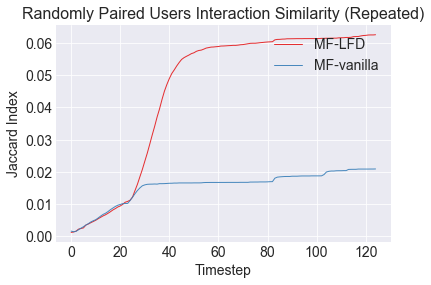

In [13]:
plot_metric(df1=mflfd_metrics, df2=mf_metrics, model1_lab='MF-LFD', model2_lab='MF-vanilla', 
            metric_var='interaction_similarity', ylab="Jaccard Index", 
            title="Randomly Paired Users Interaction Similarity (Repeated)")

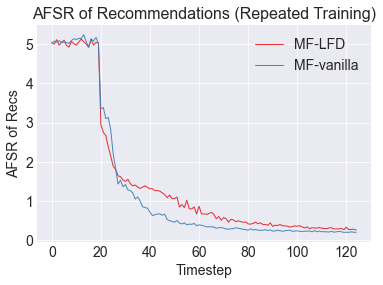

In [14]:
plot_metric(df1=mflfd_metrics, df2=mf_metrics, model1_lab='MF-LFD', model2_lab='MF-vanilla', 
            metric_var='afsr', ylab="AFSR of Recs", 
            title="AFSR of Recommendations (Repeated Training)")

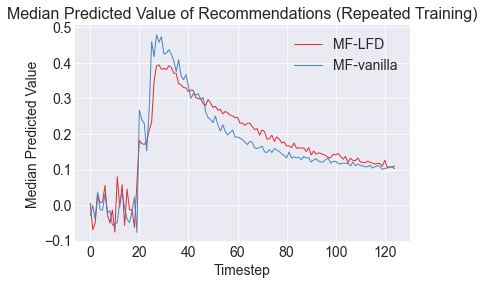

In [15]:
plot_metric(df1=mflfd_metrics, df2=mf_metrics, model1_lab='MF-LFD', model2_lab='MF-vanilla', 
            metric_var='shown_median_prediction', ylab="Median Predicted Value", 
            title="Median Predicted Value of Recommendations (Repeated Training)")

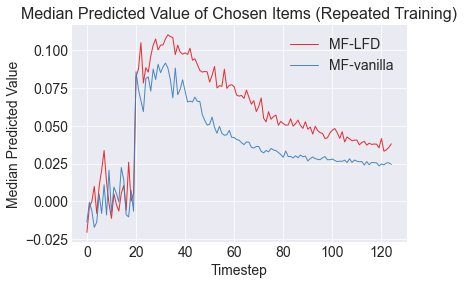

In [16]:
plot_metric(df1=mflfd_metrics, df2=mf_metrics, model1_lab='MF-LFD', model2_lab='MF-vanilla', 
            metric_var='interacted_median_prediction', ylab="Median Predicted Value", 
            title="Median Predicted Value of Chosen Items (Repeated Training)")

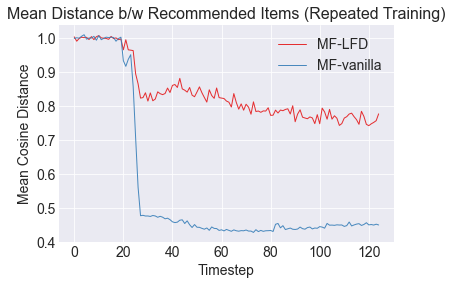

In [17]:
plot_metric(df1=mflfd_metrics, df2=mf_metrics, model1_lab='MF-LFD', model2_lab='MF-vanilla', 
            metric_var='mean_rec_distance', ylab="Mean Cosine Distance", 
            title="Mean Distance b/w Recommended Items (Repeated Training)")

In [ ]:
mf.predicted_scores.value[0].shape

In [ ]:
# mf_mean = np.mean(mf.predicted_scores.value, axis=0)
# plt.hist(mf_mean)
# plt.show()

# lfd_mean = np.mean(mflfd.predicted_scores.value, axis=0)
# plt.hist(lfd_mean)
# plt.show()

# plt.figure(figsize=(15, 15))
# plt.scatter(np.array(mf.predicted_scores.value).flatten(), mf.actual_user_item_scores.flatten())
# plt.xlabel("Predicted Scores")
# plt.ylabel("Actual Scores")

In [ ]:
mlsmall = MovieLens('../../MovieLens/data/ml-latest-small')
ratings=mlsmall.ratings

#make some fake interactions based on the ratings data
ratings["interaction"]=np.where(ratings["rating"]>=4, 1, 0)
ratings=ratings[ratings["interaction"]==1]
ratings = ratings[['user', 'item']]

algo_als = als.ImplicitMF(10, iterations=100)
algo_als.fit(ratings)
preds_als = batch.predict(algo_als, mlsmall.ratings)
#preds_als = pd.merge(preds_als, mlsmall.ratings, on=['user', 'item'])

preds_als.head(20)

In [ ]:
#preds_als.head(30)

plt.figure(figsize=(5, 5))
plt.scatter(preds_als["prediction"], preds_als["rating"], s=1)
plt.xlabel("Predicted Interaction Scores")
plt.ylabel("Actual Rating Scores")

In [ ]:
als_item_features = pd.DataFrame(als.item_features_)
mflfd_item_features = pd.DataFrame(mflfd.items_hat.T)
#mflfd_item_features.head()

mf_item_features = pd.DataFrame(mf.items_hat.T)
#mf_item_features.head()

In [ ]:
def plot_hist_features(features_df, model_type, color='blue'):
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 12}

    plt.rc('font', **font)

    n_features = list(range(0,10))
    fig, axs = plt.subplots(math.ceil(len(n_features)/3), 3, figsize=(20,20))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
    fig.suptitle('Latent Factors for {}'.format(model_type), size=20)

    for idx, n_feature in enumerate(n_features):
        r=idx //3
        c=idx % 3

        #hat = features_df[n_feature].tolist()
        features = features_df[n_feature].tolist()
        axs[r, c].set_title('Factor {}'.format(n_feature))

        #axs[r,c].plot(hat, actual, 'o', color=color);
        axs[r,c].hist(features, color=color)

    #for ax in axs.flat:
    #    ax.set(xlabel='hat representation', ylabel='actual representation')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()

    fig.delaxes(axs[3][1])
    fig.delaxes(axs[3][2])

In [ ]:
plot_hist_features(als_item_features, 'MovieLens MF')

In [ ]:
plot_hist_features(mflfd_item_features, 'MF-LFD', 'red')

In [ ]:
plot_hist_features(mf_item_features, 'MF', 'green')

In [ ]:
mflfd

In [ ]:
mflfd.predicted_scores.value.shape

In [ ]:
median_predicted_std = np.std(predicted_rec_vals)
median_predicted_std

In [ ]:
# user_representation = Generator().binomial(
#     n=1, p=.3, size=(NUM_USERS, N_FACTORS)
# )

# item_representation = Generator().binomial(
#     n=1, p=.3, size=(N_FACTORS, NUM_ITEMS)
# )
# # Initialize with custom representations
# filtering = ContentFiltering(user_representation=user_representation,
#                             item_representation=item_representation)

# filtering.add_metrics(AverageFeatureScoreRange())
# filtering.run(10)

# filtering.get_measurements()
#u = ChaneyUsers(np.copy(known_scores), size=(NUM_USERS, NUM_ATTRS), num_users=NUM_USERS, attention_exp=ATTENTION_EXP, repeat_items=False)

In [ ]:
recommended_item_predictions = mflfd.predicted_scores.value[:, mflfd.rec]
recommended_item_predictions.shape

In [ ]:
mf.all_interactions.sort_values('user').head()

In [ ]:
mf_test = ImplicitMF(num_users=10, num_items=100, num_latent_factors=N_FACTORS, num_items_per_iter=10,
                model_params=model_params)
#mf.add_metrics(MSEMeasurement())
#mf.add_metrics(AverageFeatureScoreRange())
#mf.add_metrics(RecSimilarity(pairs=js_pairs))
mf_test.add_metrics(ShownMedianPrediction())
mf_test.add_metrics(InteractedMedianPrediction())
mf_test.add_metrics(MeanRecDistance())
mf_test.add_state_variable(mf.predicted_scores)
#mf_test.add_state_variable(mf.users.actual_user_scores)
mf_test.startup_and_train(NUM_STARTUP)
mf_test.run(timesteps=NUM_STEPS, train_between_steps=True, reset_interactions=False)
#mf.run(timesteps=NUM_STEPS)

In [ ]:
mf_test_metrics = pd.DataFrame(mf_test.get_measurements())
mf_test_metrics.head(30)

In [ ]:
# mf_scores = pd.DataFrame(mf.predicted_scores.value)
# cols = [f"item_{c}" for c in mf_scores.columns]
# mf_scores.columns = cols
# #mf_scores.head()
# mf_scores["user"] = list(range(mf_scores.shape[0]))


# # t=pd.wide_to_long(mf_scores, "item_", i="user", j="item").reset_index()
# # t.columns = ["user", "item", "predicted_score"]

In [ ]:
final_step_len = len(str(NUM_STEPS + NUM_STARTUP))

for t in range(NUM_STEPS + NUM_STARTUP):

    X=mf.predicted_scores.state_history[t].flatten()
    Y=mf.users.actual_user_scores.state_history[t].flatten()

    # plt.scatter(X, Y)
    # plt.figure(figsize=(15, 15))

    fig, ax = plt.subplots(figsize=(10,10))
    fig.set_tight_layout(True)
    ax.set(xlim=(-5, 5), ylim=(-5, 5))
    ax.set_xlabel("Predicted Score")
    ax.set_ylabel("Actual Score")
    ax.scatter(X,Y, s=1, alpha=.7)
    
    step_len=len(str(t))
    
    num_leading_zeros = final_step_len-step_len
    
    ext=str('0'*num_leading_zeros) + str(t)
    
    
    
    
    
    # Save it & close the figure
    filename='/Users/amywinecoff/Documents/CITP/Research/Github/scatters/mf/scatter_step'+ext+'.png'
    plt.savefig(fname=filename, dpi=96)
    plt.gca()
    plt.close(fig)


os.chdir('/Users/amywinecoff/Documents/CITP/Research/Github/scatters/mf')


In [ ]:
!convert -delay 20 scatter*.png animated_scatter_mf.gif
